In [2]:
import numpy as np
import cvxpy as cp
import scipy.io.wavfile as wav
from numpy.fft import fft
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import signal

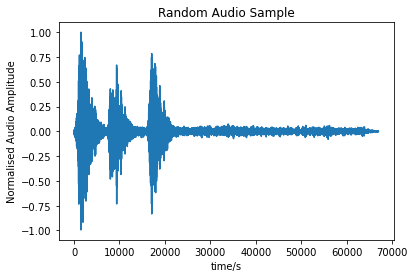

The sampling frequency of the audio is 16000 Hz


In [3]:
# reading the target audio file 
# fs is the sampling frequency
fs, y = wav.read("lowpass\\1.wav")
# normalize the signal amplitude
y = y / y.max()
plt.plot(y)
plt.xlabel("time/s")
plt.ylabel("Normalised Audio Amplitude")
plt.title("Random Audio Sample")
plt.show()
print(f'The sampling frequency of the audio is {fs} Hz')

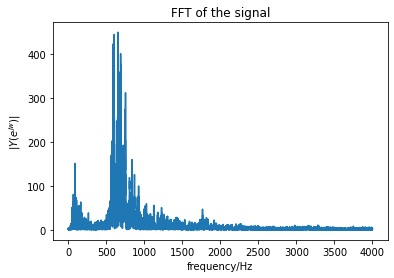

In [4]:
# generate frequency spectrum of the signal
freq = np.linspace(0, fs/2, len(y)//2+1)
freq = freq[:len(freq)//2]
y_fft = fft(y)
y_fft = np.abs(y_fft[0:len(y)//2+1])
y_fft = y_fft[:len(y_fft)//2]
plt.plot(freq, y_fft)
plt.xlabel("frequency/Hz")
plt.ylabel("$|Y(e^{jw})|$")
plt.title("FFT of the signal")
plt.show()

Text(0.5, 1.0, 'FFT points for classification')

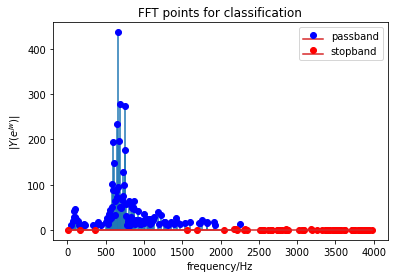

In [6]:
num_sample = 500
sample_index = np.linspace(0, len(freq)-1, num_sample).astype(int)
plt.figure()
freq_new = freq[sample_index]
fft_new = y_fft[sample_index]
# threshold for determining the stop and passband
upp_threshold = 10
low_threshold = 1
idx = np.argwhere(fft_new > upp_threshold)
idx2 = np.argwhere(fft_new <= low_threshold)
plt.stem(freq_new[idx], fft_new[idx],markerfmt='bo', label='passband')
plt.stem(freq_new[idx2], fft_new[idx2],markerfmt='ro', label='stopband')
plt.legend()
plt.xlabel("frequency/Hz")
plt.ylabel("$|Y(e^{jw})|$")
plt.title("FFT points for classification")

In [8]:
pos = np.hstack((freq_new[idx], np.zeros((len(freq_new[idx]), 1))))
neg = np.hstack((freq_new[idx2], np.zeros((len(freq_new[idx2]), 1))))
X = np.r_[pos, neg]
Y = np.zeros(len(idx) + len(idx2))
Y[0:len(idx)] = 1

# SVM classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
# Cutoff Frequency (HZ) for the filter
fc = -clf.intercept_[0]/w[0]
# Convert f_c to angular frequency
w_c = (fc/fs)*2*np.pi
print(f"The cutoff frequency is {w_c:.2f} radians/sample")
fc

The cutoff frequency is 0.74 radians/sample


1896.6168298926175

Code partially adapted from the example given by CVXPY solver 

https://www.cvxpy.org/examples/basic/socp.html

proper citation given in the final report

In [37]:
# Setting random seed of optimization solver
np.random.seed(928065+1042806)

# N is the FIR filter length
# it represents the number of filter coefficients
N = 103

# Quantized Frequencies
# m is the number of constraints
# it specifies the number of quantized frequency
m = 300
w_c_quantized = np.linspace(-np.pi, np.pi, m)
pass_idx = np.argwhere(np.absolute(w_c_quantized) <= w_c)
stop_idx = np.argwhere(np.absolute(w_c_quantized) > w_c)

# ideal frequency response
H_c = np.zeros(m,dtype=np.complex_)
H_c[pass_idx] = np.exp(-1j*(N-1)*0.5*w_c_quantized[pass_idx])
H_c[stop_idx] = 0

# passband and stopband error 
# for constructing weight function
epsilon_p = 0.01
epsilon_s = 0.03
weight = np.zeros(m)
weight[pass_idx] = 1
weight[stop_idx] = epsilon_p/epsilon_s

# n_i is the row dimension for matrix A_i in ||A_i x+b_i||
# each row is for the real and imaginary component for the frequency response
n_k = 2

# lists to store all the constraints 
A = []
b = []
c = np.zeros(N + 1)
c[0] = 1

# define constraints
for i in range(m):
    w = w_c_quantized[i]
    A_m = np.zeros((2, N+1))
    for j in range(1, N+1):
        A_m[0][j] = np.cos(w*(j-1))
        A_m[1][j] = np.sin(w*(j-1))
    A_m = weight[i]*A_m
    b_m = weight[i]*np.array([-np.real(H_c[i]), np.imag(H_c[i])])
    A.append(A_m)
    b.append(b_m)


# define optimization problem
x = cp.Variable(N+1)
soc_constraints = [cp.SOC(c.T@x, A[i]@x - b[i]) for i in range(m)]
prob = cp.Problem(cp.Minimize(c.T@x), soc_constraints)
prob.solve()

# Print result.
h = x.value[1:]
# scale the coefficients so that the maximum filter magnitude sits at 1
# freq, mag = signal.freqz(h)
# scale = 1/max(abs(mag)); 
# h = h*scale
print("The optimal filter coefficients are")
print(h)

The optimal filter coefficients are
[-0.13941834  0.07952438  0.04598293  0.01663427 -0.00506216 -0.0139833
 -0.00097186 -0.00556456  0.00563404  0.01277781  0.01609406  0.01363605
  0.00488204 -0.00137865 -0.00687363 -0.00705186 -0.002826    0.00407808
  0.01091553  0.01247306  0.00918528  0.00168541 -0.00595499 -0.01008646
 -0.00877628 -0.00159623  0.00739658  0.0139643   0.01409186  0.00729198
 -0.00325822 -0.01274605 -0.01568258 -0.01006479  0.00226308  0.01532941
  0.02203014  0.01807048  0.00382431 -0.01443143 -0.02758029 -0.02732377
 -0.01092948  0.01619728  0.04190755  0.05123554  0.03299345 -0.01531905
 -0.08490656 -0.15782662 -0.21298146 -0.23346479 -0.21298146 -0.15782662
 -0.08490656 -0.01531905  0.03299345  0.05123554  0.04190755  0.01619728
 -0.01092948 -0.02732377 -0.02758029 -0.01443143  0.00382431  0.01807048
  0.02203014  0.01532941  0.00226308 -0.01006479 -0.01568258 -0.01274605
 -0.00325822  0.00729198  0.01409186  0.0139643   0.00739658 -0.00159623
 -0.00877628 -0.

Text(0, 0.5, '$|H(e^{jw})|$')

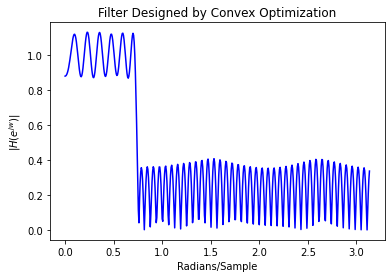

In [38]:
freq, mag = signal.freqz(h)
plt.plot(freq, abs(mag), color='b')
plt.title("Filter Designed by Convex Optimization")
plt.xlabel("Radians/Sample")
plt.ylabel("$|H(e^{jw})|$")

Text(0, 0.5, '$|H(e^{jw})|$')

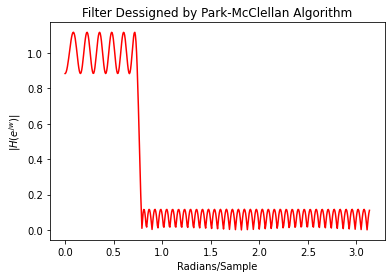

In [39]:
cutoff = fc    # Desired cutoff frequency, Hz
transition = 100  # Width of transition from pass band to stop band, Hz
numtaps = 103     # Size of the FIR filter.
h = signal.remez(numtaps, [0, fc, fc + transition, 0.5*fs], [1, 0], Hz=fs)
freq, mag = signal.freqz(h, [1])
plt.plot(freq, abs(mag), color='r')
plt.title("Filter Dessigned by Park-McClellan Algorithm")
plt.xlabel("Radians/Sample")
plt.ylabel("$|H(e^{jw})|$")